# Preprocessing

## Imports

In [1]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import ks_2samp

## Load Data

In [2]:
# check the current working directory
current_working_directory = os.getcwd()
print(current_working_directory)

/Users/albertolandi/Documents/GitHub/ML2_Practice/ML2_Project/modelo_normal


In [3]:
PATH = '/Users/albertolandi/Documents/GitHub/ML2_Practice/ML2_Project'

# load data
data = pd.read_csv(f'{PATH}/dataset/AEP_hourly.csv')

# Display the first few rows of the dataframe
data.head()

,Datetime,AEP_MW
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


In [4]:
# Display dataframe information
print("\nDataFrame Information:\n")
data.info()


DataFrame Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [5]:
# Display summary statistics
print("\nSummary Statistics:\n")
data.describe()


Summary Statistics:



,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


## Raw Data Visualization

1. Time Series Plot of AEW_MW

In [6]:
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
data.dropna(subset=['Datetime'], inplace=True)  # Drop rows with invalid dates
data.sort_values(by='Datetime', inplace=True)  # Sort values by date

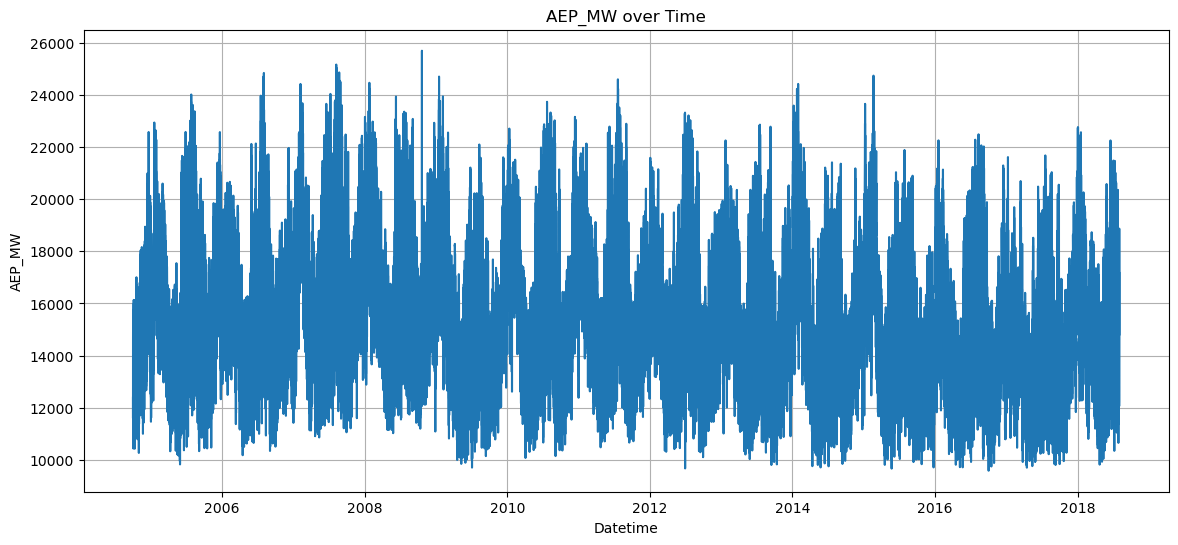

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(data['Datetime'], data['AEP_MW'])
plt.title('AEP_MW over Time')
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.grid(True)
plt.show()

2. Histogram of AEP_MW

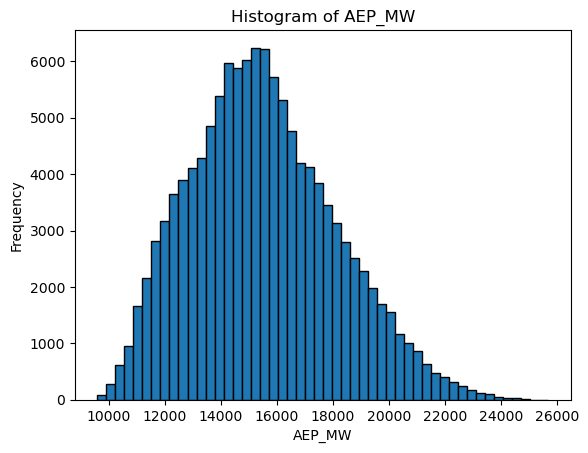

In [8]:
plt.Figure(figsize=(8, 5))
plt.hist(data['AEP_MW'], bins=50, edgecolor='black')
plt.title('Histogram of AEP_MW')
plt.xlabel('AEP_MW')
plt.ylabel('Frequency')
plt.show()

3. Box Plot of AEP_MW

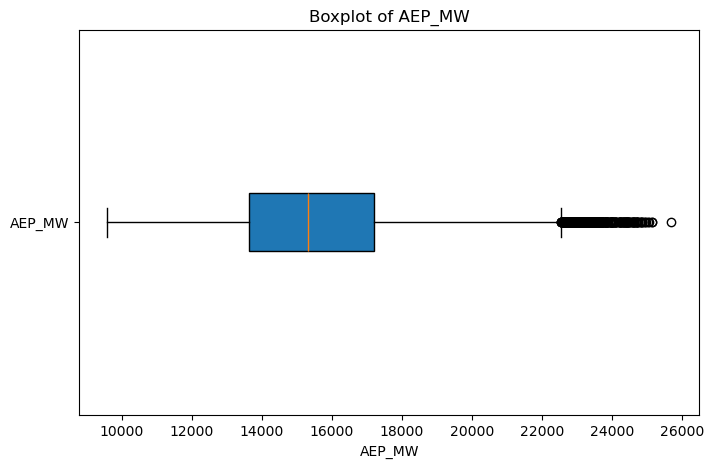

In [9]:
plt.figure(figsize=(8, 5))
plt.boxplot(data['AEP_MW'], vert=False, patch_artist=True, tick_labels=['AEP_MW'])
plt.title('Boxplot of AEP_MW')
plt.xlabel('AEP_MW')
plt.show()

## Concept Drift


In [10]:
def detect_seasonal_drift(data, feature, season_length=2160, p_threshold=0.01, diff_threshold=0.1):
    """
    Detect concept drift on a seasonal basis.

    Parameters:
    data (pd.DataFrame): The dataframe containing the time series data.
                         Must have a DatetimeIndex.
    feature (str): The feature to check for concept drift.
    season_length (int):  The length of a "season" in data points (hours, in this case).
    p_threshold (float):  KS test p-value threshold.
    diff_threshold (float): Minimum relative mean difference.

    Returns:
    list:  Indices where seasonal drift is detected.  These indices will
           correspond to the *end* of the first season in each comparison.
    """
    drift_points = []
    values = data[feature].values
    n_seasons = len(values) // season_length

    for i in range(1, n_seasons):  # Compare consecutive seasons
        start1 = (i - 1) * season_length
        end1 = i * season_length
        start2 = i * season_length
        end2 = (i + 1) * season_length if (i + 1) < n_seasons else len(values) #Handle the last partial season

        window1 = values[start1:end1]
        window2 = values[start2:end2]

        # KS Test
        ks_stat, p_value = ks_2samp(window1, window2)

        # Mean Difference
        mean1 = np.mean(window1)
        mean2 = np.mean(window2)
        if mean1 != 0:
           relative_diff = abs(mean2 - mean1) / abs(mean1)
        else:
            relative_diff = 0

        # Combined Condition
        if p_value < p_threshold and relative_diff > diff_threshold:
            drift_points.append(end1)  # Append the *end* of the first window

    return drift_points

In [11]:
# Detect concept drift (with combined criteria)
drift_points = detect_seasonal_drift(data, 'AEP_MW', season_length=24*90, p_threshold=0.05, diff_threshold=0.05)  # 90-day seasons, stricter thresholds

In [12]:
def plot_concept_drift(data, feature, drift_points):
    """
    (Same plotting function as before, but repeated for clarity)
    Plots the time series with vertical lines at drift points.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(data.index, data[feature], label=feature)

    for point in drift_points:
        plt.axvline(data.index[point], color='red', linestyle='--', alpha=0.7)

    plt.title(f'Concept Drift Detection in {feature}')
    plt.xlabel('Datetime')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.show()

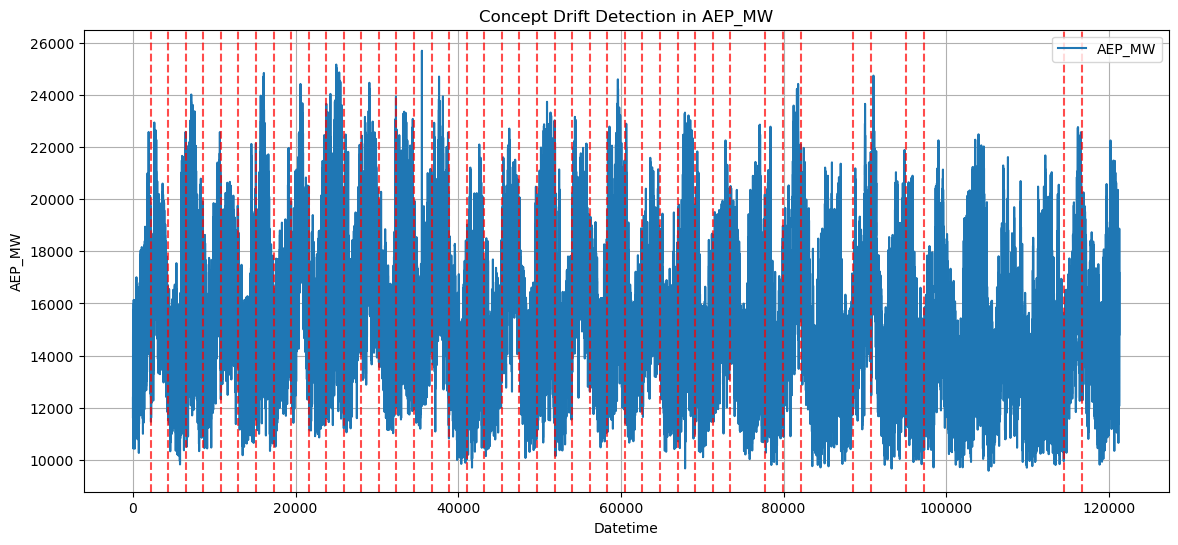

In [13]:
# Plot (with vertical lines)
plot_concept_drift(data, 'AEP_MW', drift_points)

In [14]:
print(f"Number of drift points detected: {len(drift_points)}")
if drift_points:
    print("Seasonal drift points detected at the following dates:")
    for point in drift_points:
        print(data['Datetime'].iloc[point])

Number of drift points detected: 43
Seasonal drift points detected at the following dates:
2004-12-30 02:00:00
2005-03-30 02:00:00
2005-06-28 03:00:00
2005-09-26 03:00:00
2005-12-25 04:00:00
2006-03-25 04:00:00
2006-06-23 05:00:00
2006-09-21 05:00:00
2006-12-20 06:00:00
2007-03-20 07:00:00
2007-06-18 07:00:00
2007-09-16 07:00:00
2007-12-15 08:00:00
2008-03-14 09:00:00
2008-06-12 09:00:00
2008-09-10 09:00:00
2008-12-09 10:00:00
2009-03-09 11:00:00
2009-06-07 11:00:00
2009-09-05 11:00:00
2009-12-04 12:00:00
2010-03-04 12:00:00
2010-06-02 13:00:00
2010-08-31 13:00:00
2010-11-29 14:00:00
2011-02-27 15:00:00
2011-05-28 16:00:00
2011-08-26 16:00:00
2011-11-24 17:00:00
2012-02-22 17:00:00
2012-05-22 18:00:00
2012-08-20 18:00:00
2012-11-18 19:00:00
2013-02-16 20:00:00
2013-08-15 21:00:00
2013-11-13 22:00:00
2014-02-11 22:00:00
2014-11-08 23:00:00
2015-02-06 23:00:00
2015-08-06 00:00:00
2015-11-03 23:00:00
2017-10-24 00:00:00
2018-01-21 23:00:00


## Feature Engineering

In [15]:
def create_features(df):
    """
    Creates time series features from datetime index, mirroring River's logic.
    """
    # Convert Datetime to datetime objects, handling potential errors
    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

    # Create date features, handling NaT (Not a Time) values
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['WeekOfYear'] = df['Datetime'].dt.isocalendar().week  # Access the week attribute
    df['DayOfWeek'] = df['Datetime'].dt.dayofweek
    df['DayOfYear'] = df['Datetime'].dt.dayofyear
    df['Weekend'] = (df['Datetime'].dt.dayofweek >= 5).astype(int)
    df['Quarter'] = df['Datetime'].dt.quarter
    df['Hour'] = df['Datetime'].dt.hour
    df['Date'] = df['Datetime'].dt.date # Create a 'date' column for consistency.
    return df

def rolling_mean_features(df, windows=[7, 14], column='AEP_MW'):
    """
    Calculates rolling mean features, similar to River's TargetAgg.
    """
    for window in windows:
        df[f'last_{window}_mean'] = df[column].rolling(window=window, min_periods=1).mean() #min_periods = 1 is important
    return df


def lag_features(df, lags=[1], columns=['AEP_MW']):
    """
    Create time lag features, keep it to use if you want to test other lags.
    """
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    return df

def pipeline(data):
    """
    Feature engineering pipeline, closely matching the River pipeline.
    """
    df = data.copy()
    df = create_features(df)
    df = rolling_mean_features(df, windows=[7, 14])
    df = lag_features(df, lags=[1], columns=['AEP_MW']) #If you want to keep the name "LastDay" you can rename AEP_MW_lag_1
    df.rename(columns={'AEP_MW_lag_1':'LastDay'}, inplace=True) #Keep consistency with the river pipeline names.
    # df = df.drop(columns=['Datetime', 'Date'])  # Drop the original Datetime
    df.dropna(inplace=True)  # Drop rows with NaN values *after* feature creation
    return df

df0 = data.copy()

df = pipeline(data)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121272 entries, 1 to 121272
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Datetime      121272 non-null  datetime64[ns]
 1   AEP_MW        121272 non-null  float64       
 2   Year          121272 non-null  int32         
 3   Month         121272 non-null  int32         
 4   Day           121272 non-null  int32         
 5   WeekOfYear    121272 non-null  UInt32        
 6   DayOfWeek     121272 non-null  int32         
 7   DayOfYear     121272 non-null  int32         
 8   Weekend       121272 non-null  int64         
 9   Quarter       121272 non-null  int32         
 10  Hour          121272 non-null  int32         
 11  Date          121272 non-null  object        
 12  last_7_mean   121272 non-null  float64       
 13  last_14_mean  121272 non-null  float64       
 14  LastDay       121272 non-null  float64       
dtypes: UInt32(1), datetime

In [16]:
df['Year'].value_counts()

Year
2016    8784
2008    8782
2012    8781
2015    8760
2017    8760
2014    8759
2005    8758
2006    8758
2007    8758
2009    8758
2011    8758
2013    8758
2010    8757
2018    5136
2004    2205
Name: count, dtype: int64

## Visualization of cyclical features over time

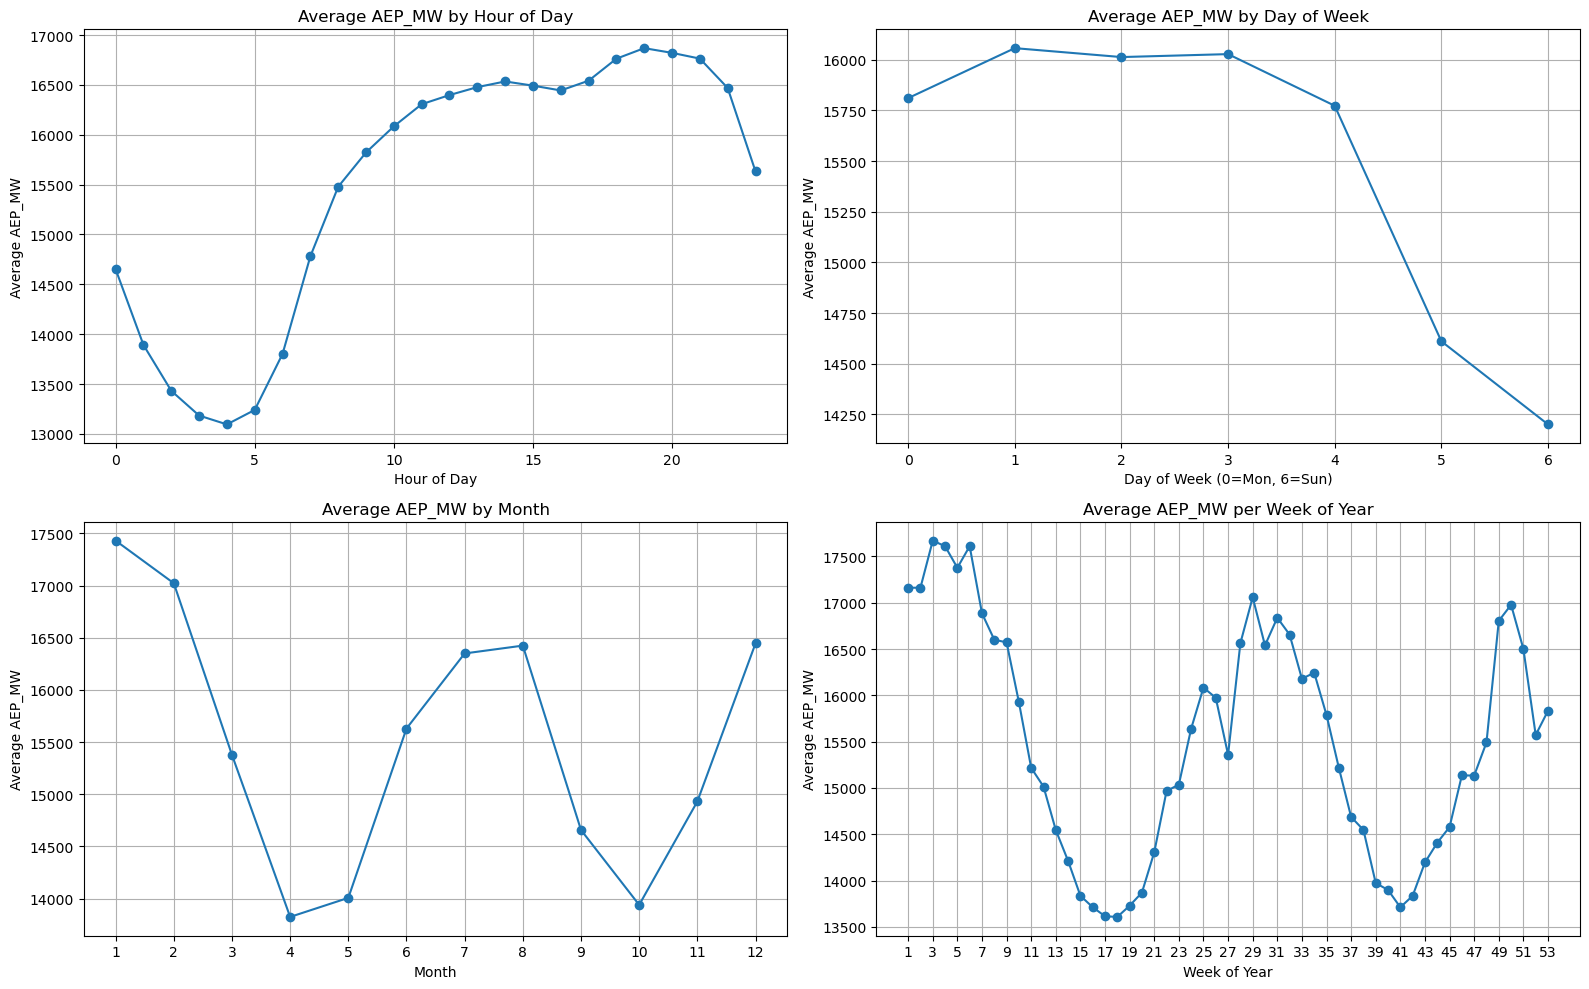

In [17]:
plt.figure(figsize=(16, 10))

# Average AEP_MW per Hour
plt.subplot(2, 2, 1)
df.groupby('Hour')['AEP_MW'].mean().plot(marker='o')
plt.title('Average AEP_MW by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average AEP_MW')
plt.grid(True)

# Average AEP_MW per Day of Week
plt.subplot(2, 2, 2)
df.groupby('DayOfWeek')['AEP_MW'].mean().plot(marker='o', xticks=range(7), rot=0)
plt.title('Average AEP_MW by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Average AEP_MW')
plt.grid(True)

# Average AEP_MW per Month
plt.subplot(2, 2, 3)
df.groupby('Month')['AEP_MW'].mean().plot(marker='o', xticks=range(1, 13), rot=0)
plt.title('Average AEP_MW by Month')
plt.xlabel('Month')
plt.ylabel('Average AEP_MW')
plt.grid(True)

#Average AEP_MW per WeekOfYear
plt.subplot(2,2,4)
df.groupby('WeekOfYear')['AEP_MW'].mean().plot(marker='o', xticks=range(1,54,2), rot=0) #Plot every two weeks to avoid crowded X axis
plt.title('Average AEP_MW per Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average AEP_MW')
plt.grid(True)


plt.tight_layout()
plt.show()

## Correlation Heatmap

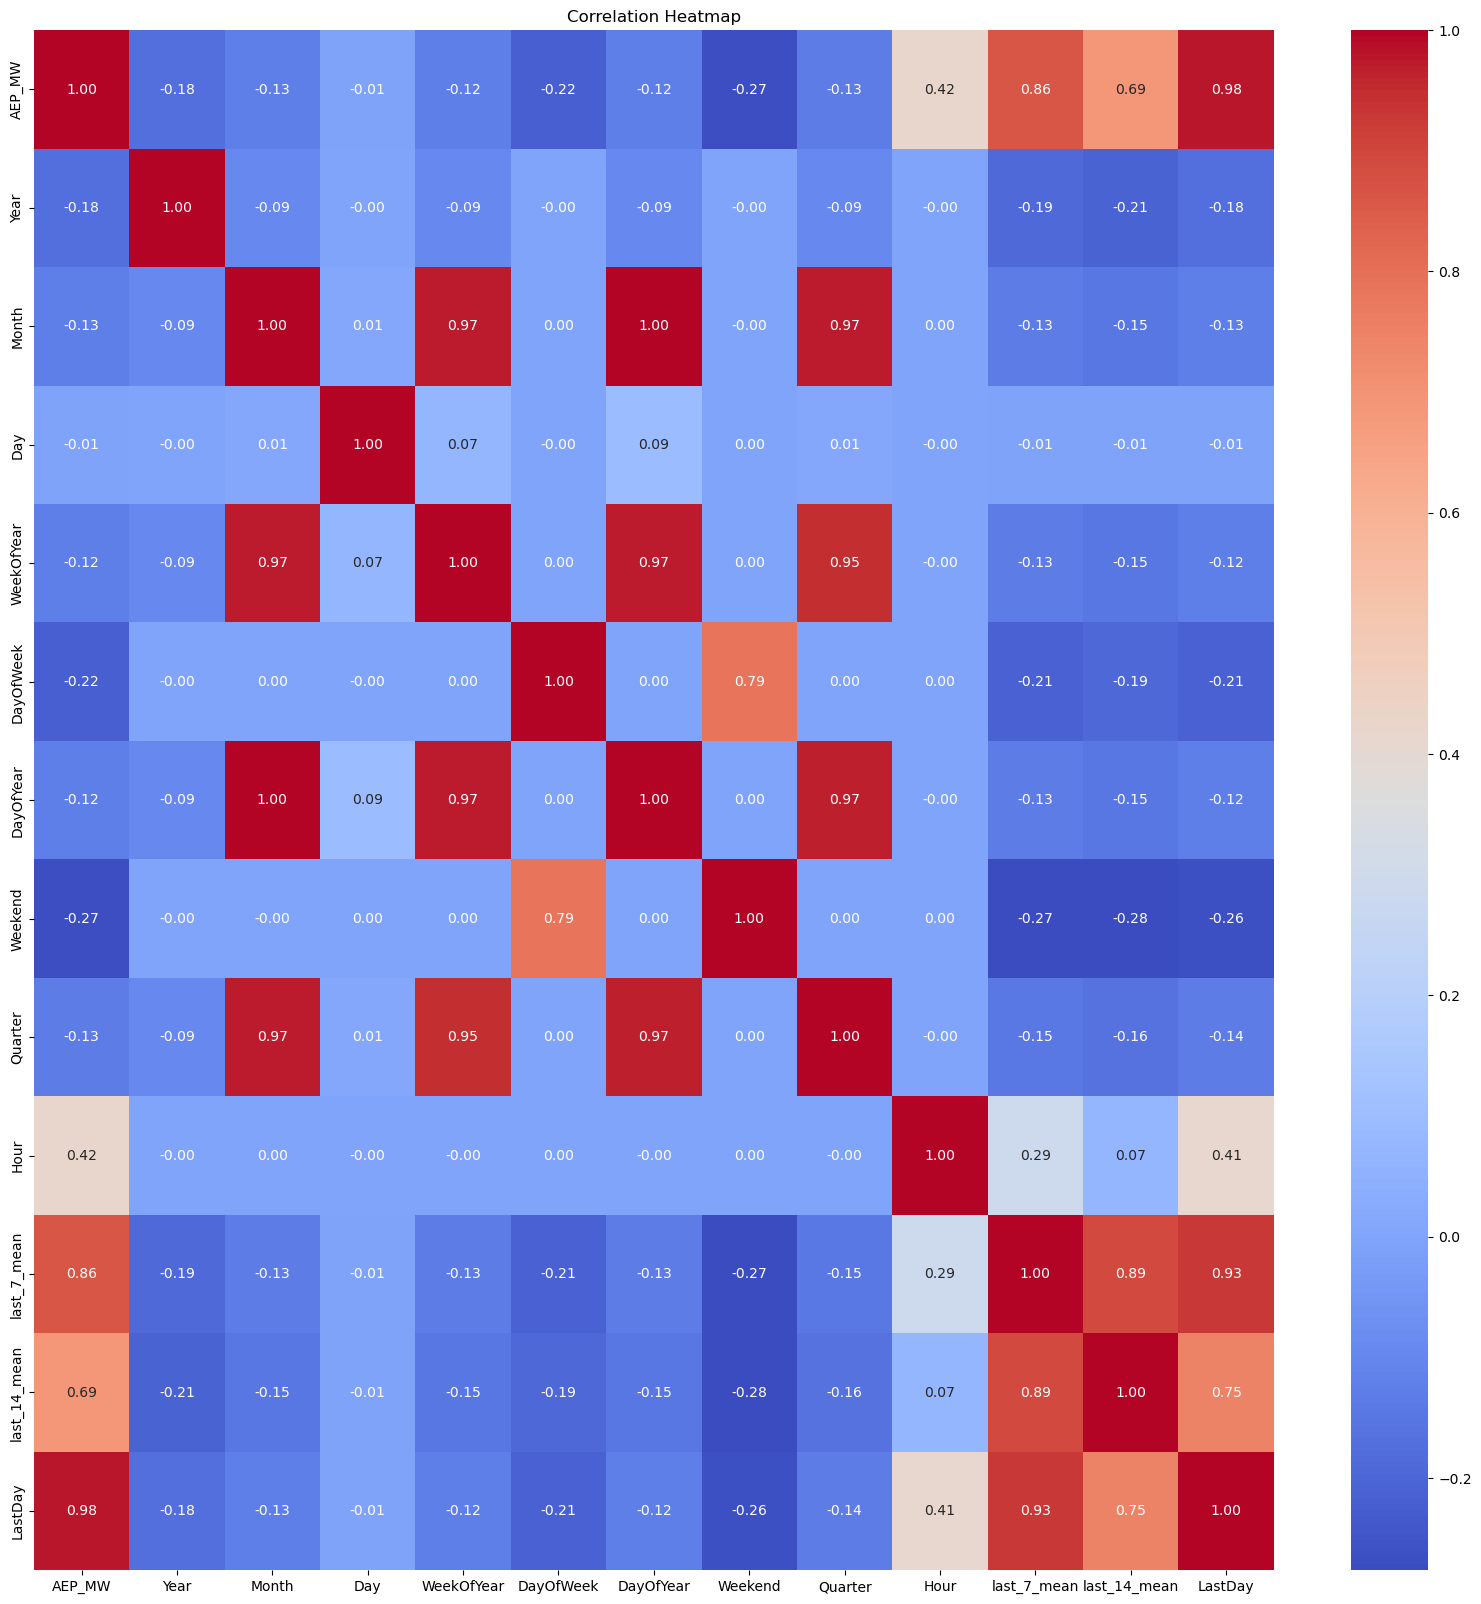

In [18]:
# Correlation heatmap
plt.figure(figsize=(20, 20))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Correlation between the target variable and the features


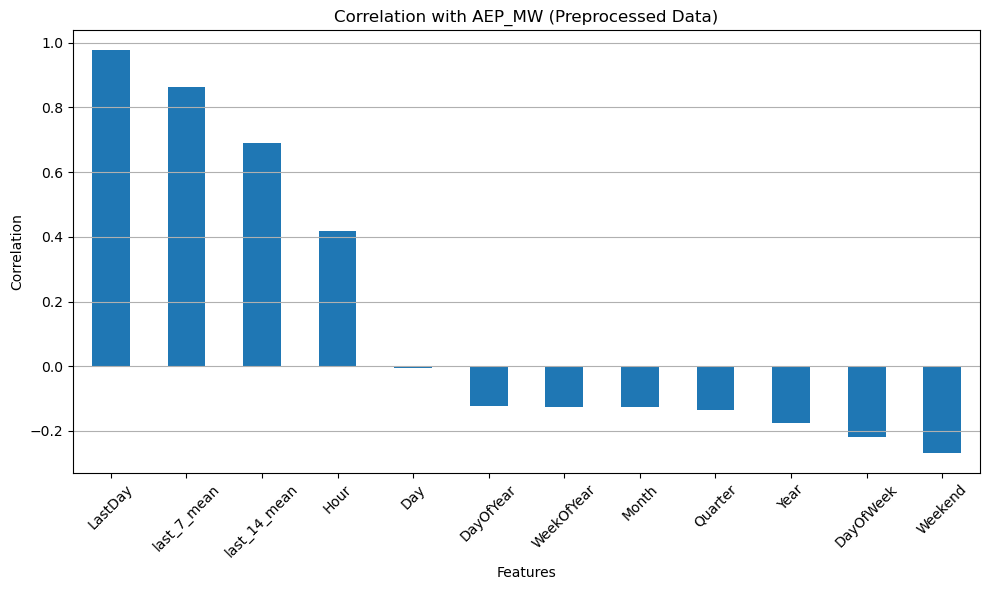

In [19]:
# visualize the correlation between the target variable and the features
plt.figure(figsize=(10, 6))  
df_corr = df.select_dtypes(include=[np.number]).corr()['AEP_MW'].sort_values(ascending=False)[1:]
df_corr.plot(kind='bar', rot=45) 
plt.title('Correlation with AEP_MW (Preprocessed Data)')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.grid(axis='y')  
plt.tight_layout()
plt.show()

## Lagged features visualization

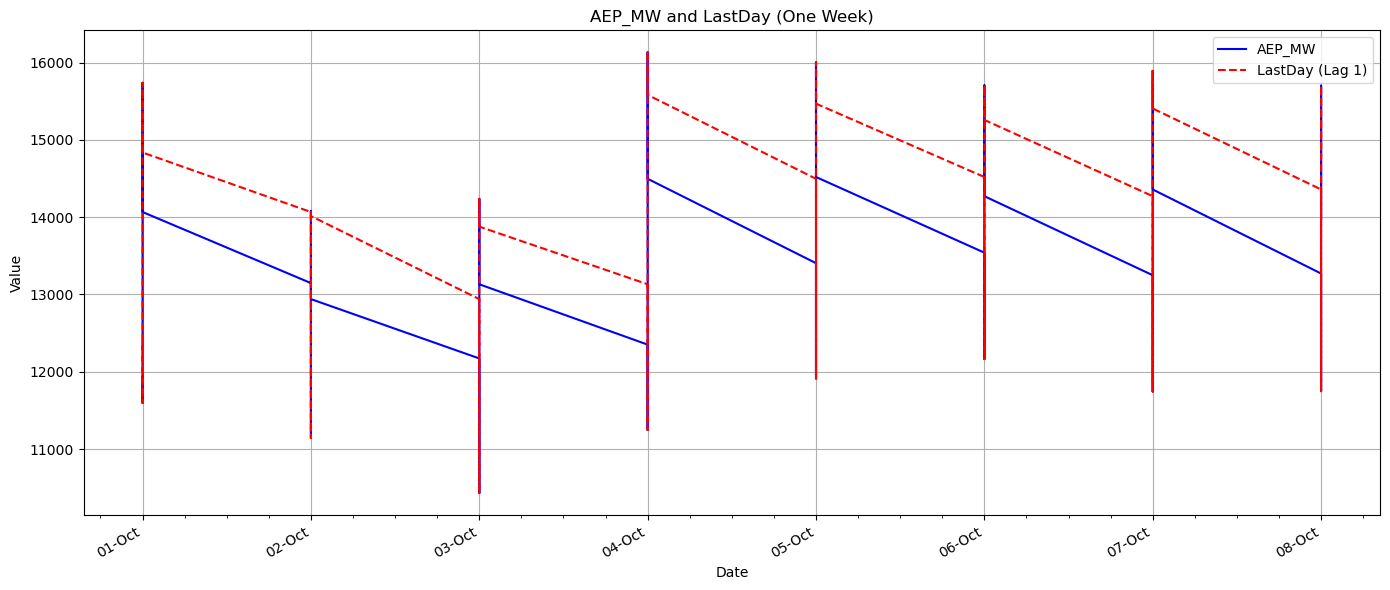

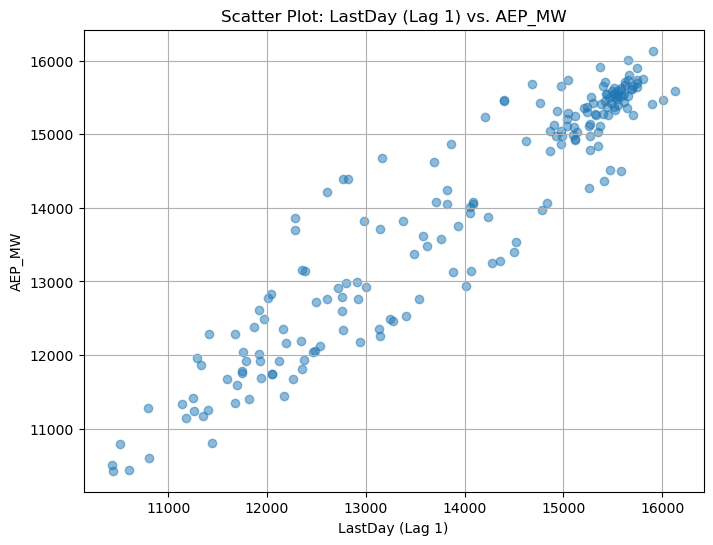

In [21]:
# Select one week of data
start_date = df['Date'].min()
end_date = start_date + pd.Timedelta(weeks=1)
subset = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

# Time Series Plot (One Week)
plt.figure(figsize=(14, 6))
plt.plot(subset['Date'], subset['AEP_MW'], label='AEP_MW', color='blue')
plt.plot(subset['Date'], subset['LastDay'], label='LastDay (Lag 1)', color='red', linestyle='--')
plt.title('AEP_MW and LastDay (One Week)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Date formatting for the x-axis:
#   - Major ticks:  Every day
#   - Minor ticks:  Every 6 hours (optional, for finer detail)
#   - Date format:  Day-Month (e.g., "01-Jan")
date_fmt = mdates.DateFormatter('%d-%b')  # Format: Day-Month
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Major ticks every day
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))  # Minor ticks every 6 hours
plt.gcf().autofmt_xdate() 

plt.tight_layout()
plt.show()

# Scatter Plot (Lag 1 vs. AEP_MW) - No change needed here
plt.figure(figsize=(8, 6))
plt.scatter(subset['LastDay'], subset['AEP_MW'], alpha=0.5)
plt.title('Scatter Plot: LastDay (Lag 1) vs. AEP_MW')
plt.xlabel('LastDay (Lag 1)')
plt.ylabel('AEP_MW')
plt.grid(True)
plt.show()

## Export Data

In [22]:
print(PATH)

/Users/albertolandi/Documents/GitHub/ML2_Practice/ML2_Project


In [23]:
# Save the preprocessed data
df.to_csv(f'{PATH}/dataset/AEP_hourly_preprocessed-v2.csv', index=False)